# Tools for Responsibly Purchasing and Selling Single-Family Residences in the Midwest
# Final Report
##### Colin Simon - 4/10/2020


## Executive Summary
Purchasing and selling real estate is one of the most impactful decisions individuals make. It must be done responsibly and with care.
The tool below observes residential sales data from Ames, Iowa and can be used to make price predictions - or rather, checks on price, similar to Kelly Blue Book.

- Our conclusions are best suited for those targeting single-family homes, as opposed to duplexes, apartments, condos, or other multifamily buildings.
- This model also focuses on "typical" market sale real estate transactions and does not cover alternative sale types.
- We recommend using this tool as a "sanity check" for dealing with real estate agents; it can be helpful in ensuring that agents' recommendations actually benefit the client.

### Contents:
- [1. Imports](#1.-Imports)
- [2. Exploratory Data Analysis(EDA)](#2.-Exploratory-Data-Analysis(EDA))
- [3. Cleaning](#3.-Cleaning)
- [4. Feature Engineering](#4.-Feature-Engineering)<br>
-    [4.1 Features List](#4.1-Features-List)<br>
-    [4.2 Additional Key Items](#4.2-Additional-Key-Items)
-    [4.3 Outlier Cleaning](#4.3-Outlier-Cleaning)
-    [4.4 Scratchpad(Testing)](#4.4-Scratchpad(Testing))
- [5. Modeling](#5.-Modeling)
- [6. Evaluation](#6.-Evaluation)
- [7. Execution and Submission](#7.-Execution-and-Submission)
- [8. Conclusions and Recommendations](#8.-Conclusions-and-Recommendations)

# 1. Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score # use for proj 2
from sklearn.metrics import r2_score
import missingno as msno
from sklearn.preprocessing import StandardScaler
from scipy import stats


%matplotlib inline


In [2]:
#import CSVs
train = pd.read_csv('datasets/train.csv')
final = pd.read_csv('datasets/test.csv')

"Final" will be the Kaggle submission dataframes, whereas "Test" will involve cross validation and other statistical trials.

# 2. EDA

In [3]:
train.shape

(2051, 81)

In [4]:
#This function will give a summary view of .dtypes and .nunique() and .isna()
def viewer(df):
    pd.set_option('display.max_columns', 85) #from Matt Burke
    view = pd.DataFrame()
    view['dtypes'] = df.dtypes
    view['nunique'] = df.nunique()
    view['nans'] = df.isna().sum()
    view['mean'] = df.mean().round(1)
    view['std dev'] = df.std().round(1)
    return view.T

In [7]:
# Inspect data
viewer(train)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
dtypes,int64,int64,int64,object,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,object,object,object,object,object,float64,object,object,object,object,object,object,object,float64,object,float64,float64,float64,object,object,object,object,int64,int64,int64,int64,float64,float64,int64,int64,int64,int64,object,int64,object,int64,object,object,float64,object,float64,float64,object,object,object,int64,int64,int64,int64,int64,int64,object,object,object,int64,int64,int64,object,int64
nunique,2051,2051,16,7,118,1476,2,2,4,4,3,5,3,28,9,8,5,8,10,9,113,61,6,6,15,15,4,373,4,5,6,5,5,4,6,821,6,205,967,892,5,5,2,5,915,504,31,1053,4,3,5,3,8,4,4,14,8,5,5,6,100,3,6,514,5,5,3,322,223,159,22,100,10,4,4,5,28,12,5,9,828
nans,0,0,0,0,330,0,0,1911,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,22,0,0,0,55,55,58,55,1,56,1,1,1,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,1000,113,114,114,1,1,114,114,0,0,0,0,0,0,0,2042,1651,1986,0,0,0,0,0
mean,1474,7.1359e+08,57,NaN,69.1,10065.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,5.6,1971.7,1984.2,NaN,NaN,NaN,NaN,NaN,99.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,442.3,NaN,48,567.7,1058,NaN,NaN,NaN,NaN,1164.5,329.3,5.5,1499.3,0.4,0.1,1.6,0.4,2.8,1,NaN,6.4,NaN,0.6,NaN,NaN,1978.7,NaN,1.8,473.7,NaN,NaN,NaN,93.8,47.6,22.6,2.6,16.5,2.4,NaN,NaN,NaN,51.6,6.2,2007.8,NaN,181470
std dev,844,1.88692e+08,42.8,NaN,23.3,6742.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4,1.1,30.2,21,NaN,NaN,NaN,NaN,NaN,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,461.2,NaN,165,445,449.4,NaN,NaN,NaN,NaN,396.4,425.7,51.1,500.4,0.5,0.3,0.5,0.5,0.8,0.2,NaN,1.6,NaN,0.6,NaN,NaN,25.4,NaN,0.8,215.9,NaN,NaN,NaN,128.5,66.7,59.8,25.2,57.4,37.8,NaN,NaN,NaN,573.4,2.7,1.3,NaN,79258.7


In [8]:
# Look at example data
pd.set_option('display.max_columns', 85)
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


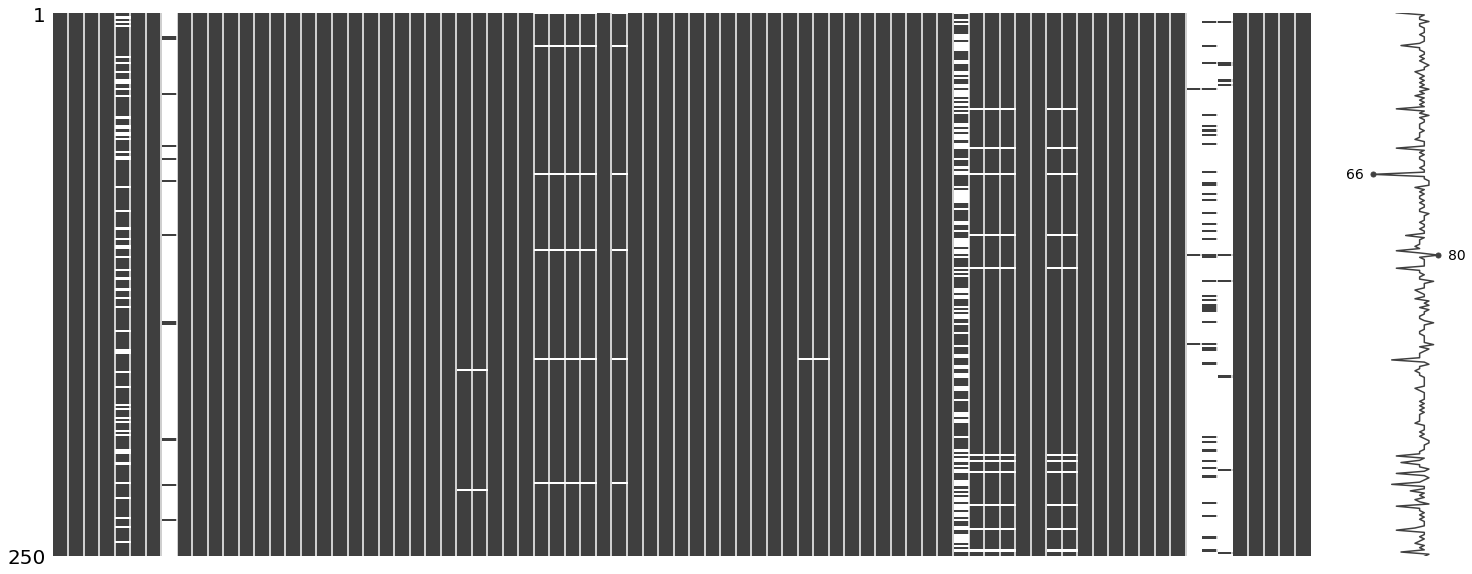

In [9]:
msno.matrix(train.sample(250));

Most of the very empty columns will simply not be included in the model.

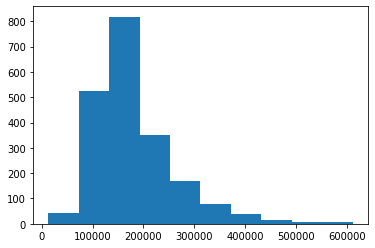

In [10]:
plt.hist(train['SalePrice']);

Outliers and correcting for skew will be done lower

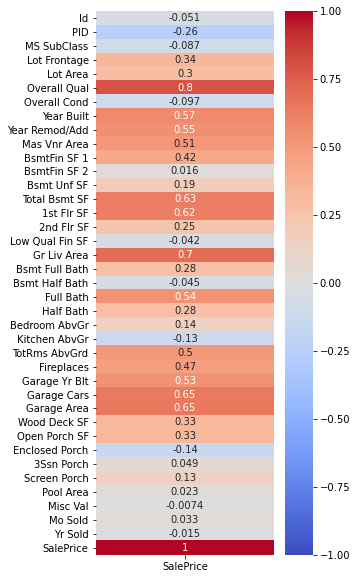

In [11]:
plt.figure(figsize=(4,10))
sns.heatmap(train.corr()[['SalePrice']],
            annot=True,
            cmap='coolwarm',
           vmin=-1,
           vmax=1);

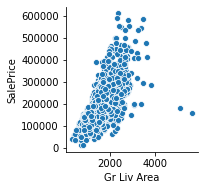

In [13]:
sns.pairplot(train, x_vars=['Gr Liv Area'], y_vars=['SalePrice']);

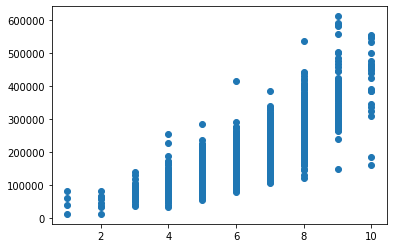

In [14]:
plt.scatter(train['Overall Qual'], train['SalePrice']);

Quality metric looks somewhat like the log curve, but not dramatically so. Not sure if log should be used for this or not.

In [15]:
#view counts
train['Neighborhood'].value_counts()

NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
Timber      48
NoRidge     48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
NPkVill     17
Veenker     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

# 3. Cleaning

In [16]:
# View Sale Types
train.groupby('Sale Type').count()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,SalePrice
Sale Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
COD,63,63,63,63,48,63,63,9,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,62,62,62,62,63,62,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,21,62,62,62,63,63,62,62,63,63,63,63,63,63,63,0,17,2,63,63,63,63
CWD,10,10,10,10,8,10,10,1,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,0,3,0,10,10,10,10
Con,4,4,4,4,4,4,4,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,0,0,4,4,4,4
ConLD,17,17,17,17,16,17,17,3,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,12,12,12,12,16,12,16,16,16,17,17,17,17,17,17,17,17,16,16,17,17,17,17,17,17,17,17,1,15,15,15,17,17,15,15,17,17,17,17,17,17,17,0,3,0,17,17,17,17
ConLI,7,7,7,7,6,7,7,1,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,4,6,6,6,7,7,6,6,7,7,7,7,7,7,7,0,1,1,7,7,7,7
ConLw,5,5,5,5,5,5,5,0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,2,5,5,5,5,5,5,5,5,5,5,5,5,5,5,0,0,0,5,5,5,5
New,160,160,160,160,158,160,160,11,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,149,149,160,160,160,160,160,159,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,105,158,158,158,160,160,158,158,160,160,160,160,160,160,160,1,0,1,160,160,160,160
Oth,4,4,4,4,3,4,4,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,3,3,3,4,4,3,3,4,4,4,4,4,4,4,0,2,0,4,4,4,4
WD,1781,1781,1781,1781,1473,1781,1781,115,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,1770,1770,1781,1781,1781,1732,1732,1730,1732,1781,1731,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,1780,1780,1781,1781,1781,1781,1781,1781,1781,1781,908,1675,1674,1674,1780,1780,1674,1674,1781,1781,1781,1781,1781,1781,1781,8,374,61,1781,1781,1781,1781


Let's remove all of the sale types that appear irregular

In [17]:
# Remove outlier
train = train[train['Sale Type'] != 'COD']
train = train[train['Sale Type'] != 'CWD']
train = train[train['Sale Type'] != 'Con']
train = train[train['Sale Type'] != 'ConLD']
train = train[train['Sale Type'] != 'ConLI']
train = train[train['Sale Type'] != 'ConLw']
train = train[train['Sale Type'] != 'Oth']
# There was probably a shorter way to do this

In [19]:
# Observe changes
train.shape

(1941, 81)

In [20]:
#Fix NaN in garage cars or garage area. 
#Set to 0 because they probably just don't have garages
train.loc[train["Garage Area"].isnull(), 'Garage Cars'] = 0

In [21]:
#Here we are checking for neighborhoods that appear in Test but do not appear in Train, and vice-versa
a = set(final['Neighborhood'])
b = set(train['Neighborhood'])
a.difference(b)

set()

In [22]:
b.difference(a)

{'GrnHill', 'Landmrk'}

GrnHill and Landmrk are the only ones that don't appear in the testing data.

In [23]:
#Building Type is something we will want to filter as well. Remove multifamily bldgs
train.groupby('Bldg Type').count()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Bldg Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1Fam,1607,1607,1607,1607,1340,1607,1607,86,1607,1607,1607,1607,1607,1607,1607,1607,1607,1607,1607,1607,1607,1607,1607,1607,1607,1587,1587,1607,1607,1607,1580,1580,1577,1580,1607,1579,1607,1607,1607,1607,1607,1607,1607,1607,1607,1607,1607,1606,1606,1607,1607,1607,1607,1607,1607,1607,1607,885,1543,1542,1542,1607,1606,1542,1542,1607,1607,1607,1607,1607,1607,1607,9,350,58,1607,1607,1607,1607,1607
2fmCon,43,43,43,43,41,43,43,10,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,41,41,41,41,43,41,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,7,27,27,27,43,43,27,27,43,43,43,43,43,43,43,0,8,2,43,43,43,43,43
Duplex,71,71,71,71,60,71,71,2,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,52,52,52,52,71,52,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,6,51,51,51,71,71,51,51,71,71,71,71,71,71,71,0,4,2,71,71,71,71,71
Twnhs,64,64,64,64,58,64,64,8,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,16,57,57,57,64,64,57,57,64,64,64,64,64,64,64,0,7,0,64,64,64,64,64
TwnhsE,156,156,156,156,132,156,156,20,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,154,154,156,156,156,155,155,155,155,156,155,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,99,155,155,155,156,156,155,155,156,156,156,156,156,156,156,0,5,0,156,156,156,156,156


# 4. Feature Engineering

### 4.1 Features List
This next cell is a compilation of most of the features I have engineered. They have been summarized here because this process of discovery was messy.

In [24]:
# log of price
train['logprice'] = np.log(train['SalePrice'])
# final['logprice'] = np.log(final['SalePrice']) # don't need to transform target variable

# explore natural log of lot area
train['log lot area'] = np.log(train['Lot Area'])
final['log lot area'] = np.log(final['Lot Area'])

#explore heat quality = excellent or not
train['heat qual ex'] = np.where(train['Heating QC']=='Ex', 1, 0)
final['heat qual ex'] = np.where(final['Heating QC']=='Ex', 1, 0)

#explore building type
train['sfr'] = np.where(train['Bldg Type'] == '1Fam', 1, 0)
final['sfr'] = np.where(final['Bldg Type'] == '1Fam', 1, 0)

#explore log of ground living area
train['log gr liv'] = np.log(train['Gr Liv Area'])
final['log gr liv'] = np.log(final['Gr Liv Area'])

#total sq ft
#Assuming null values for basement just means no basement so setting to 0
train.loc[train["Total Bsmt SF"].isnull(), 'Total Bsmt SF'] = 0
train['total sqft'] = train['Gr Liv Area'] + train['Total Bsmt SF']
final['total sqft'] = final['Gr Liv Area'] + final['Total Bsmt SF']

#bsmt qual
train['bsmt'] = np.where(train['Bsmt Qual'] == 'Fa', 1, 0)
final['bsmt'] = np.where(final['Bsmt Qual'] == 'Fa', 1, 0)

#multifamily?
train['multifam'] = np.where(train['Bldg Type'] == ('Duplex' or '2fmCon'), 1, 0)
final['multifam'] = np.where(final['Bldg Type'] == ('Duplex' or '2fmCon'), 1, 0)

#age of home
train['age'] = train['Yr Sold'] - train['Year Built']
final['age'] = final['Yr Sold'] - final['Year Built']

### 4.2 Additional Key Items
- One-off checks
- Natural log of Sale price
- Dummify location variable

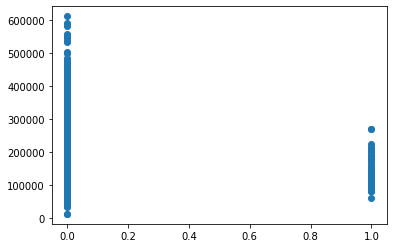

In [26]:
plt.scatter(train['multifam'], train['SalePrice']);

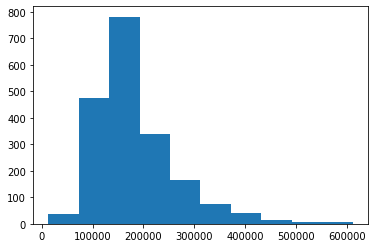

In [28]:
#Check distribution of prices
plt.hist(train['SalePrice']);

Due to heavy right skew, we should take the natural log of the sale prices.

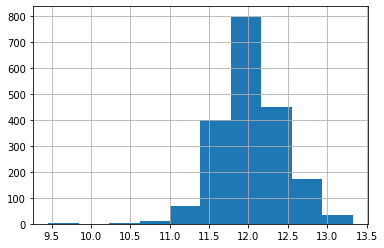

In [29]:
train['logprice'] = np.log(train['SalePrice'])
np.log(train['SalePrice']).hist();

Now we'll dummy the Neighborhoods because "location, location, location"

In [30]:
train = pd.get_dummies(train, 
                            columns=['Neighborhood'],
                           drop_first=True)
final = pd.get_dummies(final,
                            columns=['Neighborhood'],
                           drop_first=True)
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,...,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,logprice,log lot area,heat qual ex,sfr,log gr liv,total sqft,bsmt,multifam,age,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,...,NaN,0,3,2010,WD,130500,11.779129,9.511703,1,1,7.299121,2204.0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,...,NaN,0,4,2009,WD,220000,12.301383,9.349406,1,1,7.660114,3035.0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,...,NaN,0,1,2010,WD,109000,11.599103,8.977399,0,1,6.963190,2114.0,0,0,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,...,NaN,0,4,2010,WD,174000,12.066811,9.190342,0,1,7.275172,1828.0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,...,NaN,0,3,2010,WD,138500,11.838626,9.563459,0,1,7.275865,2121.0,1,0,110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### 4.3 Outlier Cleaning
- We'll use the new "total sqft" feature as one of the metrics to find outliers on the high end
- also price

In [31]:
# calc outliers by price
train['SalePrice'].median() + (3 * train['SalePrice'].std())

403641.88556923467

In [32]:
# calc outliers by square footage
train['total sqft'].median() + (3 * train['total sqft'].std())

4914.795039037696

In [33]:
# remove outliers
train = train.loc[train['SalePrice'] < 405_000]
train = train.loc[train['total sqft'] < 4912]
train.shape

(1894, 116)

Down from ~2050 data points

### 4.4 Scratchpad(Testing)
- Lines that experimentally detracted from the model have been commented out.

In [34]:
finals = [
#   'Lot Area',
    'Overall Qual',
    'Garage Cars',
#   'log gr liv',
#   'Gr Liv Area',
#   'log gr liv',
#   'Full Bath',
    'log lot area',
    'heat qual ex',
    'sfr',
#   'PID',
    'total sqft',
#   'kitch bad',
#   'Garage Yr Blt',
#   'exterior',
    'bsmt',
    'multifam',
    'age',
#   'logprice',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
#  'Neighborhood_Greens',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker'
         ]

# 5. Modeling

In [35]:
# Set up variables
X = train[finals]
y = train['logprice'] #  <--- this is crucial! Will have to exponentiate later

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Instantiate model
lr = LinearRegression()

# Fit model
lr.fit(X_train, y_train);

# 6. Evaluation
#### Metrics used to evaluate the model.
- I repeatedly circled back from here to Feature Engineering and even EDA and Cleaning.
- This was also used as a "scratchpad" in that some lines of the function were commented out along with repeated experimentation.
- This was built off "function to create six metrics" from one of our labs.

In [36]:
from scipy import stats
def model_metrics(X_train, X_test, y_train, y_test, model):
    preds = model.predict(X_test)
    resids = y_test - preds
    MAE = np.abs(resids).mean() #leaning heavily on lesson 3.02 for these
    SSE = (resids ** 2).sum()
    MSE = SSE / len(resids)
    RMSE = np.sqrt(MSE).round(4)
    train_score = lr.score(X_train, y_train).round(4)
    test_score = lr.score(X_test, y_test).round(4)
    cv_score = cross_val_score(lr, X_train, y_train).mean().round(4)
#     tt = stats.ttest_ind(X_test, y_test, equal_var=False)
#     tscore = tt.statistic
#     pval = tt.pvalue.round(4)
    print(
#         f'MAE is {MAE}\n'       
#         f'SSE is {SSE}\n'
#         f'MSE is {MSE}\n'
        f'RMSE is {RMSE}\n'
        f'Cross Val score is {cv_score}\n'
        f'Train score is {train_score}\n'
        f'Test score is {test_score}')
#         f'tscore is {tscore}\n'
#         f'pval is {pval}'

In [37]:
# Run metrics
model_metrics(X_train, X_test, y_train, y_test, lr)

RMSE is 0.1651
Cross Val score is 0.8637
Train score is 0.8729
Test score is 0.805


### Evaluation conclusions:
- The R^2 values do not appear terrific
- Previous attempts with more features resulted in a higher R^2
- This attempt yielded one of the lower RMSE values (approx. 27,000 before including logarithmic target variable)
- RMSE on the log scale is totally uninterpretable to me. Is there a better way to calculate this?

## 7. Execution and Submission
#### MUST GET OUT OF LOG MODE!

In [38]:
# Create predictions

preds = np.exp(lr.predict(X_test))
pred_final = np.exp(lr.predict(final[finals]))

In [39]:
# Create residuals
resids = y_test - preds

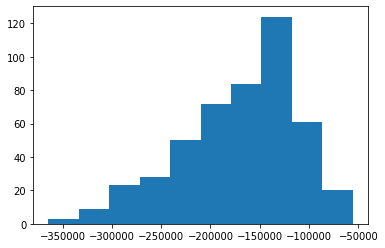

In [40]:
# View
plt.hist(resids);

In [42]:
# Initialize empty dataframe
to_submit = pd.DataFrame()

# Install ID and price
to_submit['Id'] = final['Id']
to_submit['SalePrice'] = pred_final

# Sanity check
to_submit.head()

,Id,SalePrice
0,2658,129392.497177
1,2718,181327.556440
2,2414,200147.002005
3,1989,113484.283057
4,625,171572.634409


#### Create CSV:

In [ ]:
to_submit.to_csv('./datasets/to_submit_outliers.csv', index=False)

# 8. Conclusions and Recommendations

This report returned a Root Mean Squared Error of just over $23,000$ as judged by a Kaggle competition(final scores have not yet been posted). The mean house sale price of this data set is roughly $181,000$, so we typically have an error of about 13%. Unfortunately, I do not feel safe in using this as the sole tool to submit offers or set listing prices.

This pricing tool can, however, be used for "sanity checks" when buying and selling homes. It has also created some interesting discoveries, for example the scale of value gained from improved heating systems appeared to be significant(however we did not conduct a full test of this hypothesis). So, this pricing tool may be improved and reoriented to recommending home improvements to sellers so that they can yield greater net proceeds. Likewise, buyers could potentially use this information(inversely) to identify undervalued homes as targets for flipping or investing.